# Milestone 2

This notebook aims to preprocess our data, and estimate the feasibility of the different ideas we had during the first milestone, using data exploration and some preliminary analysis.

- [Dataset description](#Dataset-description)
- [Initial dataset preprocessing](#Data-preprocessing)
    - [Characters dataset](#Characters-dataset) 
    - [Movies dataset](#Movies-dataset)
    - [Plot summaries dataset](#Plot-summaries-dataset)
- [External datasets](#External-Datasets)
- [Data merging](#Data-Merging)
    - [TMDb](#tmdb)

# Datasets description

This project utilizes a rich collection of datasets encompassing movies, characters, and plot summaries. The primary datasets include:

- **Characters Dataset** (`character.metadata.tsv`): Contains detailed metadata on movie characters and the actors portraying them. Key attributes include Wikipedia and Freebase IDs, movie release dates, character names, actor birthdates, genders, heights, ethnicities, and ages at the time of movie release.

- **Movies Dataset** (`movie.metadata.tsv`) Includes comprehensive information about movies. It features data such as Wikipedia and Freebase IDs, movie names, release dates, box office revenues, runtimes, languages, countries, and genres.

- **Plot Summaries Dataset** (`plot_summaries.text`): Offers a concise summary of movie plots, linked to movies through Wikipedia movie IDs.

### External datasets

We also use external datasets to enrich our data. More information about these datasets can be found in the [External datasets](#External-datasets) section.


In [1]:
DATA_FOLDER = "data/"
DATA_FOLDER_CMU = DATA_FOLDER + "raw/MovieSummaries/"
DATA_FOLDER_TMDB = DATA_FOLDER + "raw/TMDb/"
DATA_FOLDER_IMDB = DATA_FOLDER + "raw/IMDb/"

CMU_CHARACTER = DATA_FOLDER_CMU + "character.metadata.tsv"
CMU_MOVIE = DATA_FOLDER_CMU + "movie.metadata.tsv"
PLOT_SUMMARIES = DATA_FOLDER_CMU + "plot_summaries.txt"

TMDB_MOVIE = DATA_FOLDER_TMDB + "movies_metadata.csv"
TMDB_KEYWORDS = DATA_FOLDER_TMDB + "keywords.csv"

# https://datasets.imdbws.com/
IMDB_AKA = DATA_FOLDER_IMDB + "title.akas.tsv"
IMDB_BASIC = DATA_FOLDER_IMDB + "title.basics.tsv"

# Initial dataset preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from src.utils.preprocessing_helpers import *

## Characters dataset

In [3]:
# Load the data
df_characters = pd.read_table(
    CMU_CHARACTER,
    names=[
        "wikipedia_id",
        "freebase_id",
        "release_date",
        "character_name",
        "actor_dob",
        "actor_gender",
        "actor_height",
        "actor_ethnicity",
        "actor_name",
        "actor_age_at_movie_release",
        "freebase_actor_map_id",
        "freebase_character_id",
        "freebase_actor_id",
    ],
)
df_characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


Let's check if we can find some missing values in the dataset.

In [4]:
df_characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   wikipedia_id                450669 non-null  int64  
 1   freebase_id                 450669 non-null  object 
 2   release_date                440674 non-null  object 
 3   character_name              192794 non-null  object 
 4   actor_dob                   344524 non-null  object 
 5   actor_gender                405060 non-null  object 
 6   actor_height                154824 non-null  float64
 7   actor_ethnicity             106058 non-null  object 
 8   actor_name                  449441 non-null  object 
 9   actor_age_at_movie_release  292556 non-null  float64
 10  freebase_actor_map_id       450669 non-null  object 
 11  freebase_character_id       192804 non-null  object 
 12  freebase_actor_id           449854 non-null  object 
dtypes: float64(2),

We can identify from the output above that:
- There are some *missing values*
- Some *type are not exploitable* (e.g. the `release_date` and `actor_dob`  are `object`s, not exploitable dates)

In [5]:
print(
    "Total amount of rows that contain a NaN value: ",
    df_characters.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": df_characters.isna().sum(),
        "nan_percentage": df_characters.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  405405


,nan_sum,nan_percentage
wikipedia_id,0,0.000000
freebase_id,0,0.000000
release_date,9995,2.217814
character_name,257875,57.220488
actor_dob,106145,23.552763
actor_gender,45609,10.120288
actor_height,295845,65.645740
actor_ethnicity,344611,76.466542
actor_name,1228,0.272484
actor_age_at_movie_release,158113,35.084064


Concerning the *missing values* problem, we have 4 options: perform value imputation, not using the problematic features, dropping the rows or filling the missing values using external datasets.

Now we'll take a look at the values and see if we can find some outliers.

In [6]:
df_characters.describe(include="all")

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id
count,4.506690e+05,450669,440674,192794,344524,405060,154824.000000,106058,449441,292556.000000,450669,192804,449854
unique,NaN,64330,18476,126629,29494,2,NaN,479,134078,NaN,450669,183435,135760
top,NaN,/m/0cc8620,2008,Doctor,1908-05-30,M,NaN,/m/0dryh9k,Mel Blanc,NaN,/m/0g8ngmw,/m/0h577m2,/m/0c5vh
freq,NaN,115,5453,198,791,270257,NaN,16351,791,NaN,1,146,791
mean,1.396975e+07,NaN,NaN,NaN,NaN,NaN,1.788893,NaN,NaN,37.788523,NaN,NaN,NaN
std,1.079662e+07,NaN,NaN,NaN,NaN,NaN,4.379940,NaN,NaN,20.587870,NaN,NaN,NaN
min,3.300000e+02,NaN,NaN,NaN,NaN,NaN,0.610000,NaN,NaN,-7896.000000,NaN,NaN,NaN
25%,3.759292e+06,NaN,NaN,NaN,NaN,NaN,1.676400,NaN,NaN,28.000000,NaN,NaN,NaN
50%,1.189065e+07,NaN,NaN,NaN,NaN,NaN,1.750000,NaN,NaN,36.000000,NaN,NaN,NaN
75%,2.366501e+07,NaN,NaN,NaN,NaN,NaN,1.830000,NaN,NaN,47.000000,NaN,NaN,NaN


We find interesting results:
- How can an actors' height be 510m ? 
- How can an actor's age be negative ?

### Release date and date of birth

To tackle the type problem we can convert the `object` type to `datetime` type.

In [7]:
df_characters["release_date"] = df_characters["release_date"].apply(convert_to_datetime)
df_characters["release_date"] = pd.to_datetime(
    df_characters["release_date"], errors="coerce"
)

df_characters["actor_dob"] = df_characters["actor_dob"].apply(convert_to_datetime)
df_characters["actor_dob"] = pd.to_datetime(df_characters["actor_dob"], errors="coerce")

### Height

In [8]:
df_characters[df_characters["actor_height"] > 2.5]

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id
21619,1291587,/m/04qk12,2004-09-01,young Georgie,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,18.0,/m/0k276dx,/m/0k276dz,/m/0bggwvl
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0
59719,12206655,/m/02vvw24,NaT,Dominic,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,NaN,/m/0k276dq,/m/0h8hcr1,/m/0bggwvl
104140,17999628,/m/047n_2q,1998-01-01,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0
219383,179326,/m/018gq3,1996-11-18,Herbert,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,10.0,/m/0bggwv8,/m/0bggwvc,/m/0bggwvl
301653,4667507,/m/0cg9n6,2001-11-29,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,28.0,/m/0cg0zwp,NaN,/m/08hqh0
316621,3915041,/m/0b6lyp,2002-01-01,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,29.0,/m/02vc5p5,NaN,/m/08hqh0
341890,29290087,/m/0b3w9mr,1997-04-07,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,24.0,/m/0gvwy8x,NaN,/m/08hqh0
360967,14413223,/m/03d2rnl,2012-04-20,Young Punk Guy,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,26.0,/m/0m4q87d,/m/0k9tfs8,/m/0bggwvl


After a little search on the internet, we found that for the 510.0m problem, the actor's height is 5'10" (1.78m). We'll have to fix this value.
Concerning the 180m problem, we can guess that the actor's height is 1.80m, but we can't find any source to confirm this (internet or other rows). We should drop these rows.

In [9]:
df_characters.loc[df_characters["actor_height"] == 510, "actor_height"] = 1.78
df_characters.drop(
    df_characters[df_characters["actor_height"] > 2.5].index, inplace=True
)

### Age

Let's then take care of the age problem by removing the rows with negative age. 

In [ ]:
print(
    df_characters.loc[(df_characters["actor_age_at_movie_release"] < 0)].shape[0],
    "such rows will be removed",
)


df_characters = df_characters[df_characters["actor_age_at_movie_release"] > 0]

381 such rows will be removed


In [11]:
# Count the number of actor born after the movie release
df_characters[df_characters["actor_dob"] > df_characters["release_date"]].shape[0]

0

### Duplicates

In [12]:
# Drop the rows that have duplicates
df_characters.drop_duplicates(
    subset=["freebase_id", "freebase_actor_id", "freebase_character_id"], inplace=True
)

## Movie dataset

In [13]:
# For the movies metadata
df_movies = pd.read_table(
    CMU_MOVIE,
    names=[
        "wikipedia_id",
        "freebase_id",
        "title",
        "release_date",
        "revenue",
        "runtime",
        "languages",
        "countries",
        "genres",
    ],
    header=None,
)
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikipedia_id  81741 non-null  int64  
 1   freebase_id   81741 non-null  object 
 2   title         81741 non-null  object 
 3   release_date  74839 non-null  object 
 4   revenue       8401 non-null   float64
 5   runtime       61291 non-null  float64
 6   languages     81741 non-null  object 
 7   countries     81741 non-null  object 
 8   genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [14]:
print(
    "Total amount of rows that contain a NaN value: ",
    df_movies.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": df_movies.isna().sum(),
        "nan_percentage": df_movies.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  73498


,nan_sum,nan_percentage
wikipedia_id,0,0.000000
freebase_id,0,0.000000
title,0,0.000000
release_date,6902,8.443743
revenue,73340,89.722416
runtime,20450,25.018045
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


In [15]:
# Check for duplicate row
print("Check for duplicate entries:")
print(df_movies.duplicated().sum())

# Check for duplicated row with same name
print("Check for duplicate entries with title only:")
print(df_movies.duplicated(subset=["title"]).sum())

# Check for duplicated row with same name and date release
print("Check for duplicate entries with title and date release:")
print(df_movies.duplicated(subset=["title", "release_date"]).sum())

# Check for duplicate row with same name and runtime
print("Check for duplicate entries with title and movie runtime:")
print(df_movies.duplicated(subset=["title", "runtime"]).sum())

# Check for duplicate row with same wikipedia ID
print("Check for duplicate entries with wikipedia ID:")
print(df_movies.duplicated(subset=["wikipedia_id"]).sum())

Check for duplicate entries:
0
Check for duplicate entries with title only:
6263
Check for duplicate entries with title and date release:
103
Check for duplicate entries with title and movie runtime:
628
Check for duplicate entries with wikipedia ID:
0


We have some duplicate entries on the name, but the wikipedia ID is always unique.

In [16]:
df_movies.describe(include="all")

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres
count,8.174100e+04,81741,81741,74839,8.401000e+03,6.129100e+04,81741,81741,81741
unique,NaN,81741,75478,20389,NaN,NaN,1817,2124,23817
top,NaN,/m/02w7zz8,Alice in Wonderland,2006,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
freq,NaN,1,17,1011,NaN,NaN,33748,30300,6851
mean,1.740784e+07,NaN,NaN,NaN,4.799363e+07,1.118192e+02,NaN,NaN,NaN
std,1.098791e+07,NaN,NaN,NaN,1.121753e+08,4.360070e+03,NaN,NaN,NaN
min,3.300000e+02,NaN,NaN,NaN,1.000000e+04,0.000000e+00,NaN,NaN,NaN
25%,7.323695e+06,NaN,NaN,NaN,2.083193e+06,8.100000e+01,NaN,NaN,NaN
50%,1.777899e+07,NaN,NaN,NaN,1.063969e+07,9.300000e+01,NaN,NaN,NaN
75%,2.715573e+07,NaN,NaN,NaN,4.071696e+07,1.060000e+02,NaN,NaN,NaN


Looking at the output, we observe that:
- There a problem with the `release_date` column.
- The `runtime` column seems to have some outliers, with at least one movie with a runtime of 0, and one of 1 million minutes.

### Release date

We have a similar date problem as the one we had with the characters dataset. We'll fix it the same way.

In [17]:
# Convert the date strings to datetime objects
df_movies["release_date"] = df_movies["release_date"].apply(convert_to_datetime)
df_movies["release_date"] = pd.to_datetime(df_movies["release_date"], errors="coerce")

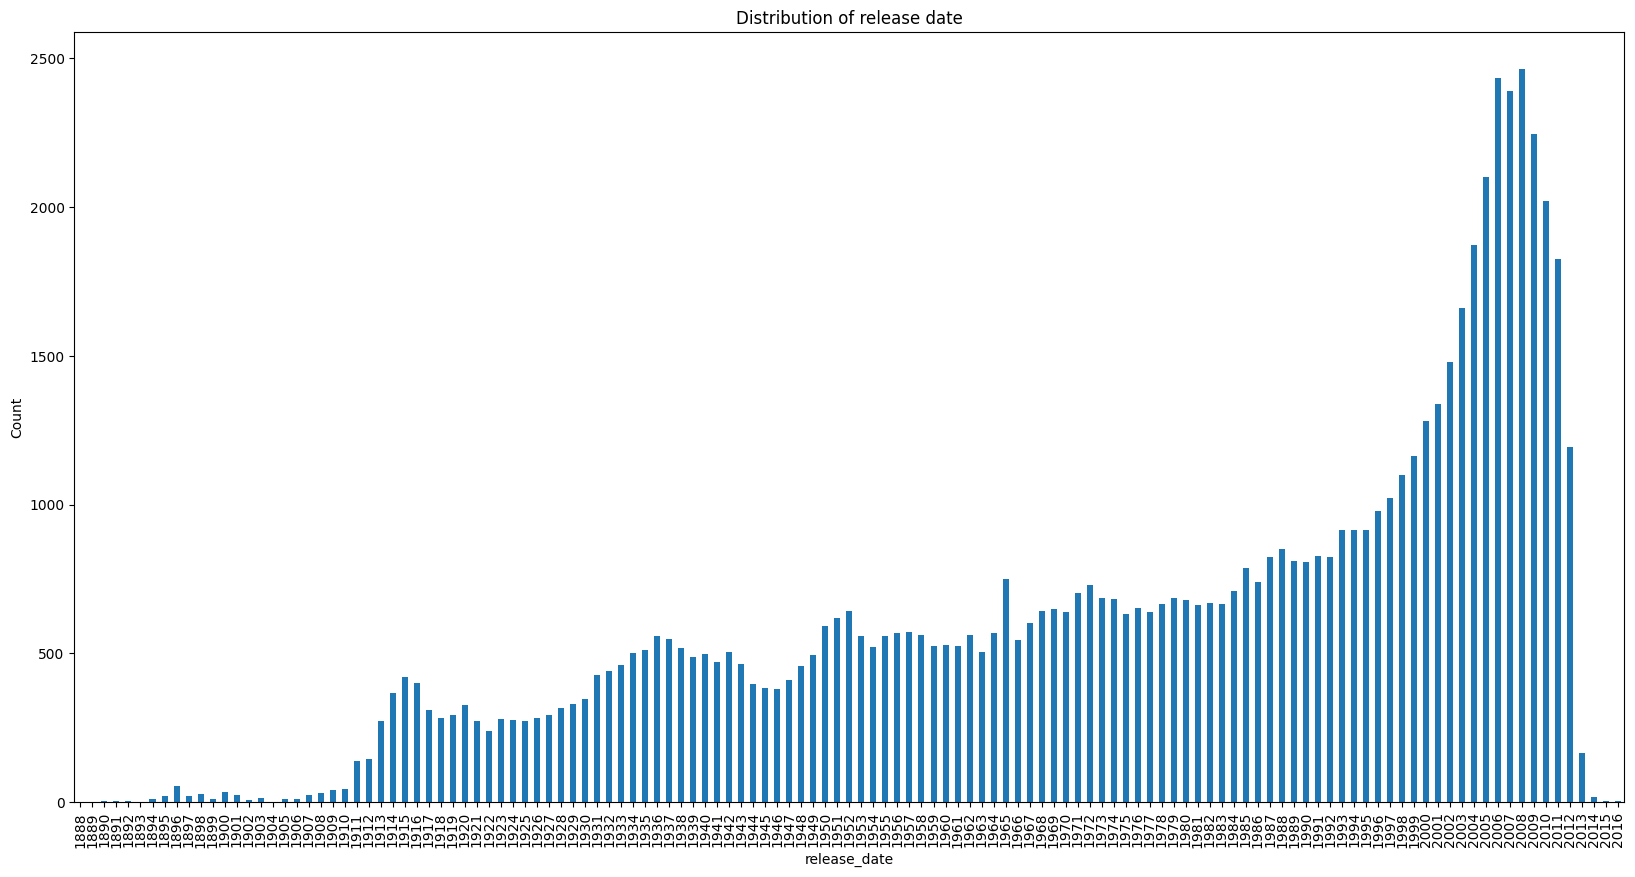

In [18]:
# Plot the distribution of the movie release date
plt.figure(figsize=(20, 10))
plt.title("Distribution of release date")
plt.xlabel("Release date")
plt.ylabel("Count")
df_movies.dropna(subset=["release_date"])[
    "release_date"
].dt.year.sort_values().value_counts(sort=False).plot(kind="bar")
plt.show()

In [19]:
print(
    f"There are {len(df_movies[df_movies['release_date'] >= pd.to_datetime('2014')])} movies are after 2014"
)

There are 24 movies are after 2014


### Runtime

We know that there are some outliers for `runtime`. We'll drop the rows with a `runtime` less or equal to 0 and greater than 500 minutes. 

In [20]:
old_shape = df_movies.shape[0]
df_movies.drop(df_movies[df_movies["runtime"] > 500].index, inplace=True)
df_movies.drop(df_movies[df_movies["runtime"] <= 0].index, inplace=True)
print(f"Have removed {old_shape - df_movies.shape[0]} rows")

Have removed 47 rows


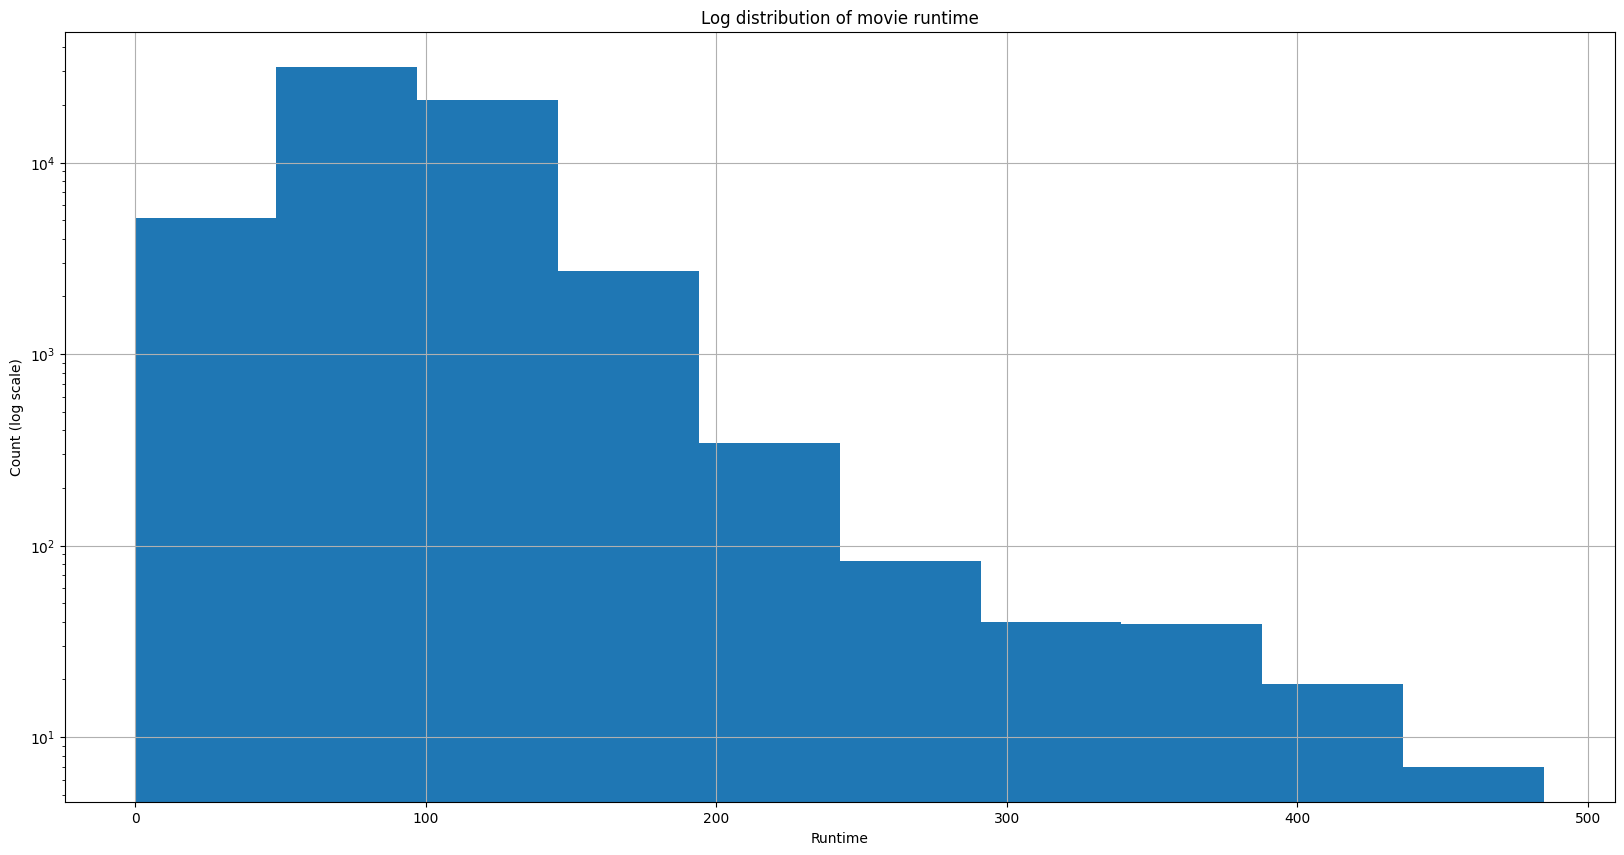

In [21]:
plt.figure(figsize=(20, 10))
plt.title("Log distribution of movie runtime")
plt.xlabel("Runtime")
plt.ylabel("Count (log scale)")
plt.yscale("log")
df_movies.dropna(subset=["runtime"])["runtime"].hist(bins=10)
plt.show()

### Genres

The `genres` feature is represented by a dict, we'll explode this column to have a row for each genre to plot them nicelly.

In [22]:
# Extract the list of genres
df_movies["genres"] = df_movies.apply(lambda row: extract_list(row, "genres"), axis=1)

# Replace empty lists by NaN
df_movies["genres"] = df_movies["genres"].apply(lambda x: np.nan if len(x) == 0 else x)

# Explode the genres
df_movies_exploded = df_movies.explode("genres")

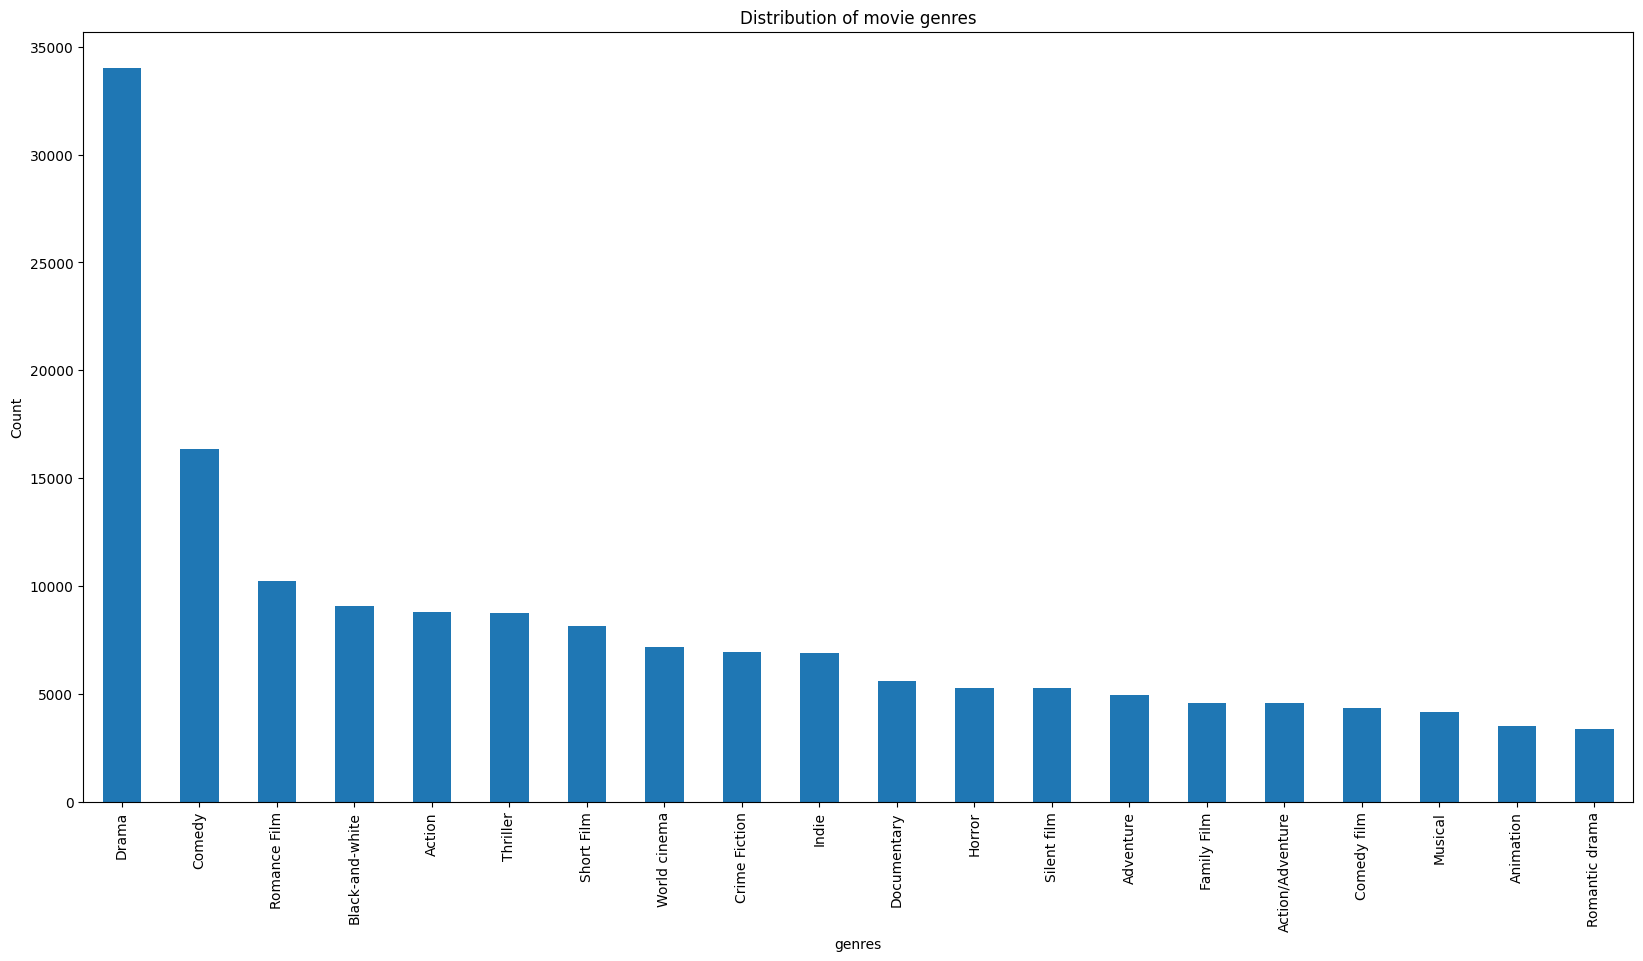

In [23]:
# Plot the distribution of movie genres, for the top 20 genres
plt.figure(figsize=(20, 10))
plt.title("Distribution of movie genres")
plt.xlabel("Movie genres")
plt.ylabel("Count")
df_movies_exploded["genres"].value_counts().head(20).plot(kind="bar")
plt.show()

### Countries

Similarly to the `genres` column, the `countries` column is a dict of countries. We'll explode this column to have a row for each country.

In [24]:
# Extract the list of countries
df_movies["countries"] = df_movies.apply(
    lambda row: extract_list(row, "countries"), axis=1
)

# Replace empty lists by NaN
df_movies["countries"] = df_movies["countries"].apply(
    lambda x: np.nan if len(x) == 0 else x
)

# Explode the countries
df_movies_exploded = df_movies.explode("countries")

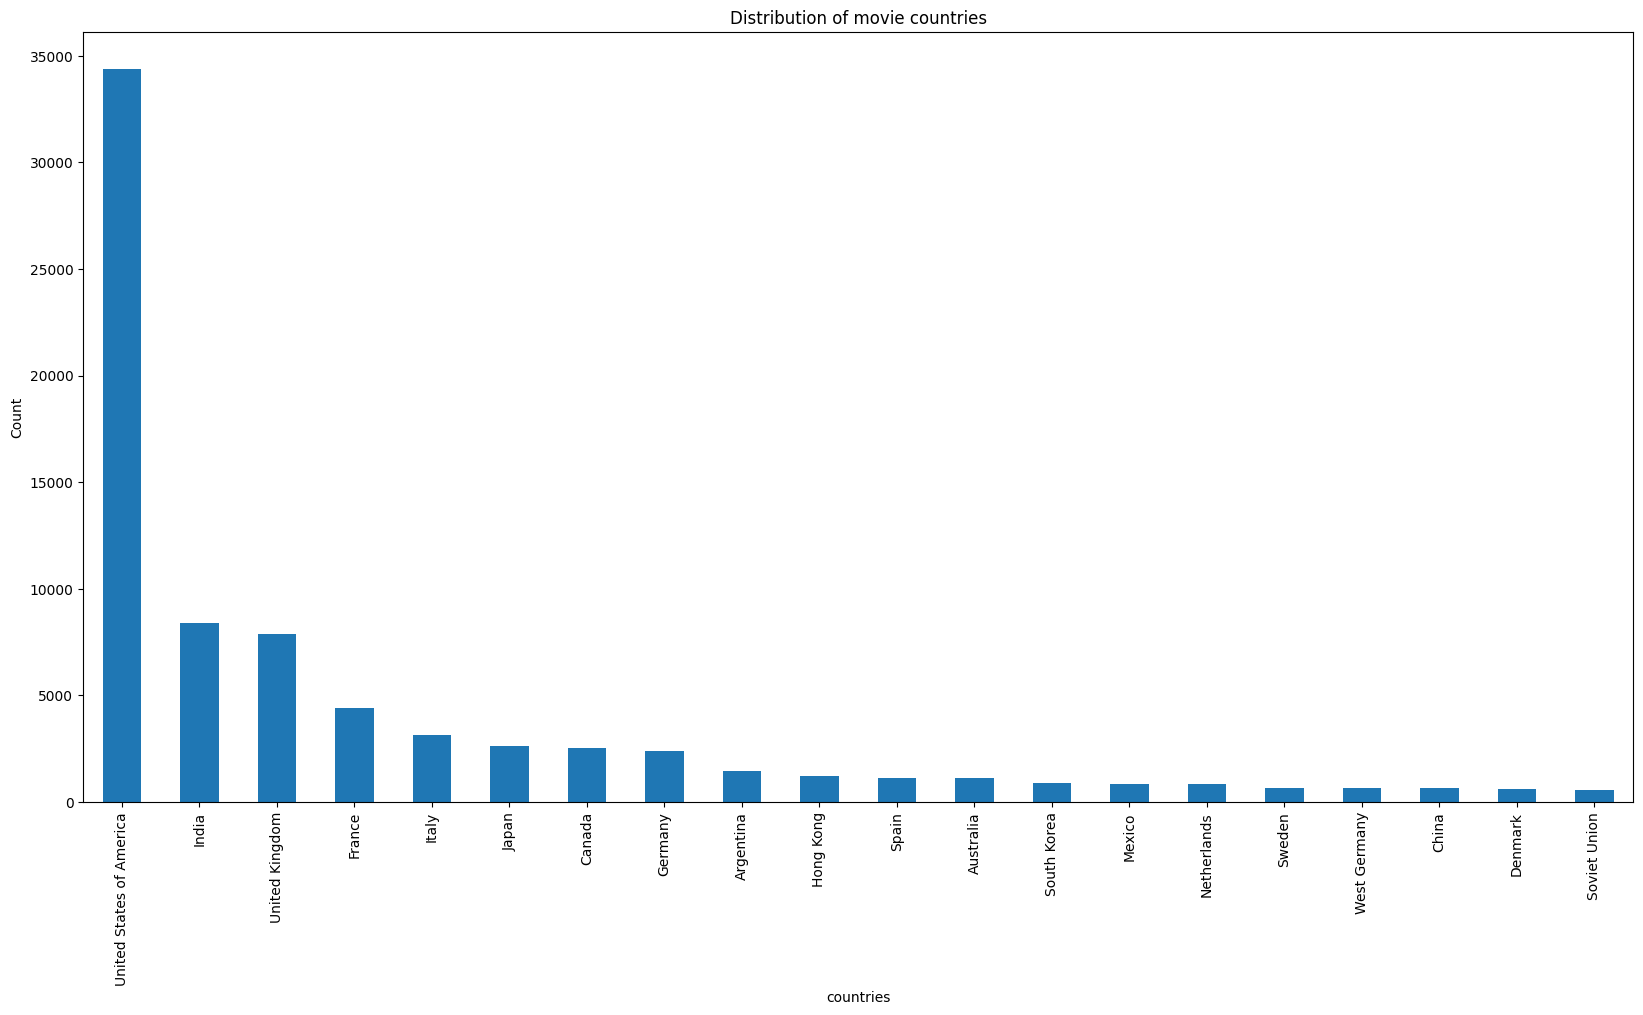

In [25]:
# Plot the distribution of movie countries, for the top 20 countries
plt.figure(figsize=(20, 10))
plt.title("Distribution of movie countries")
plt.xlabel("Movie countries")
plt.ylabel("Count")
df_movies_exploded["countries"].value_counts().head(20).plot(kind="bar")
plt.show()

We observe that US movies represent the large majority of the dataset.

### Languages

Similarly to the `genres` column, the `languages` column is a dict of languages. We'll explode this column to have a row for each language.

In [26]:
# Extract the list of languages
df_movies["languages"] = df_movies.apply(
    lambda row: extract_list(row, "languages"), axis=1
)

# Replace empty lists by NaN
df_movies["languages"] = df_movies["languages"].apply(
    lambda x: np.nan if len(x) == 0 else x
)

# Explode the languages
df_movies_exploded = df_movies.explode("languages")

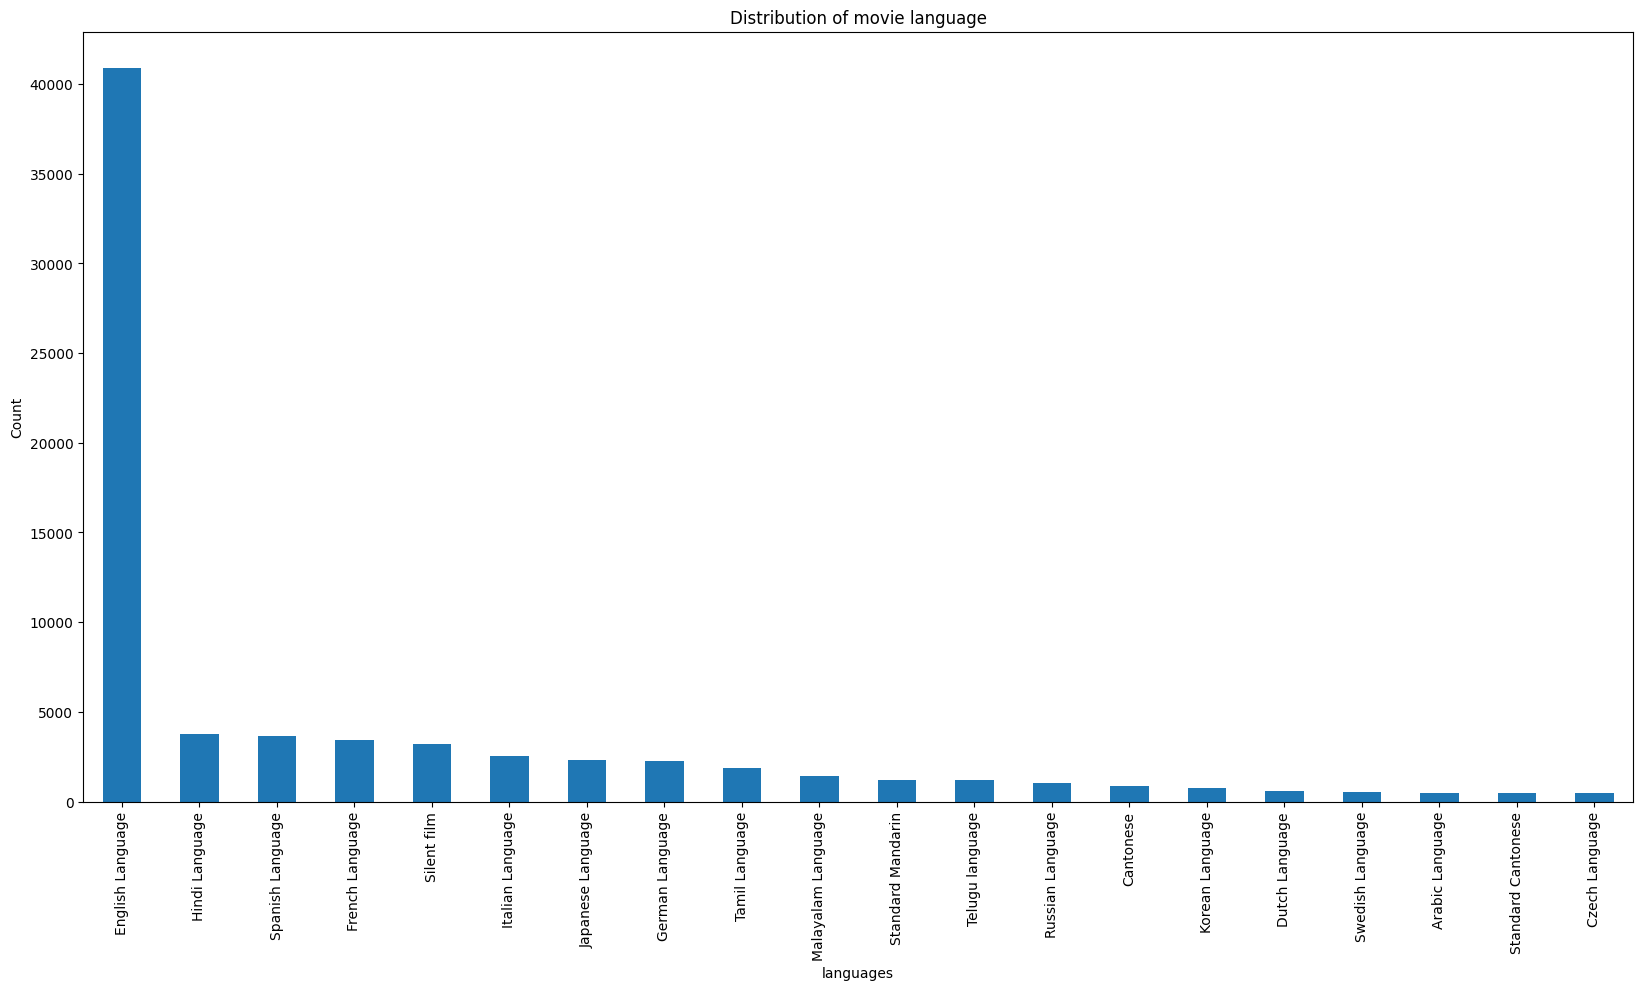

In [27]:
# Plot the distribution of movie language, for the top 20 languages
plt.figure(figsize=(20, 10))
plt.title("Distribution of movie language")
plt.xlabel("Movie language")
plt.ylabel("Count")
df_movies_exploded["languages"].value_counts().head(20).plot(kind="bar")
plt.show()

## Plot summaries dataset

In [28]:
# For the plot summaries
df_plots = pd.read_table(
    PLOT_SUMMARIES, names=["wikipedia_id", "plot_summary"], header=None
)

In [29]:
df_plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   wikipedia_id  42303 non-null  int64 
 1   plot_summary  42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [ ]:
print(
    f"There are {df_plots.duplicated(subset=['plot_summary']).sum()} duplicated plot summaries:"
)


df = pd.DataFrame(df_plots[df_plots.duplicated(subset=["plot_summary"])])


df

There are 8 duplicated plot summaries:


,wikipedia_id,plot_summary
14631,14055212,A woman is thrown out of her home by her jealo...
29428,14022275,A woman is thrown out of her home by her jealo...
30987,14051944,A woman is thrown out of her home by her jealo...
31702,14053389,A woman is thrown out of her home by her jealo...
35058,19609453,Raja was adopted by a criminal don at a very ...
38536,14616220,"As the American Civil War begins, Ned Burton l..."
38831,10791937,Taking a step aside from the usual serious dra...
39019,29481480,An orphan Raghav turns into a ruthless contrac...


There seems to be some movies with the same plot summary. 

In [31]:
df_movies[df_movies["wikipedia_id"].isin(df["wikipedia_id"])].sort_values(
    by=["wikipedia_id"]
)

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres
59142,10791937,/m/02qq36m,Ninaithale Inikkum,1979-04-14,NaN,143.0,[Tamil Language],[India],"[Romantic drama, Romance Film, Drama, World ci..."
18993,14022275,/m/03cr7rh,Madame X,1916-01-14,NaN,NaN,"[Silent film, English Language]",[United States of America],"[Silent film, Drama, Indie, Black-and-white]"
57569,14051944,/m/03cs4lh,Madame X,1954-01-01,NaN,109.0,[Greek Language],[Greece],"[Drama, Black-and-white]"
65014,14053389,/m/03cs5sb,Madame X,1981-03-16,NaN,100.0,[English Language],[United States of America],[Drama]
4551,14055212,/m/03cs72m,The Trial of Madame X,1948-01-01,NaN,54.0,[English Language],[United Kingdom],"[Drama, Black-and-white, Courtroom Drama]"
15783,14616220,/m/03gqq2m,The Warrens of Virginia,1915-02-15,NaN,NaN,"[Silent film, English Language]",[United States of America],"[Silent film, Drama, Indie, Black-and-white]"
22185,19609453,/m/05b2vs4,Amar Deep,1979-01-01,NaN,NaN,[Hindi Language],[India],"[Romance Film, Drama]"
28621,29481480,/m/0ds08gq,Drohi,1992-10-25,NaN,NaN,[Hindi Language],[India],"[Thriller, Crime Fiction, Action, Drama]"


We decide to directly merge our movie dataframe with the one with the plots 

In [32]:
# preprocess the data for merging
df_movies = preprocess_movie_data(df_movies)

df_movies = df_movies.join(df_plots.set_index("wikipedia_id"), on="wikipedia_id")

# External Datasets

- [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) contains metadata for 45,000 films listed in the Full MovieLens Dataset, all of which were released on or before July 2017. We will use this dataset, specifically the movies_metadata.csv file, primarily to enrich the movie.metadata.tsv of the CMU movie dataset. Additionally, this dataset includes plot keywords (in the keywords.csv file), which could be helpful for analyzing and clustering movie plots.

- [IMDB Non-Commercial Dataset](https://developer.imdb.com/non-commercial-datasets/) is a giant database containing over 50 Million movies from different regions, which allows us to complement our initial dataset specifically with movies created in the Soviet Union during the cold war. In addition, using the IMDB API and the IMDbPY Package, we can extract the plot to fix the issues of imbalance (The CMU Movie Summaries data being largely focused on the United States)

# Data Merging
## TMDb

In [33]:
df_tmdb_movies = pd.read_csv(
    TMDB_MOVIE,
    usecols=[
        "id",
        "title",
        "release_date",
        "revenue",
        "runtime",
        "genres",
        "production_countries",
        "original_language",
        "spoken_languages",
        "overview",
    ],
)


df_tmdb_keywords = pd.read_csv(TMDB_KEYWORDS)

In [34]:
# preprocess the data for merging
df_tmdb_movies = preprocess_movie_data(df_tmdb_movies)

# Merge the TMDB movies with keywords based on id
df_tmdb_movies["id"] = df_tmdb_movies["id"].astype(int)
df_tmdb_movies = pd.merge(df_tmdb_movies, df_tmdb_keywords, on="id", how="left")

for column_name in ["genres", "production_countries", "spoken_languages", "keywords"]:
    df_tmdb_movies[column_name] = df_tmdb_movies[column_name].apply(
        lambda row: (
            [item["name"] for item in ast.literal_eval(row)]
            if pd.notnull(row) and ast.literal_eval(row)
            else np.nan
        )
    )

# Merge based on the title
df_merged_movies = pd.merge(
    df_movies,
    df_tmdb_movies,
    on="title",
    how="outer",
    suffixes=("_original", "_additional"),
)
df_merged_movies

,wikipedia_id,freebase_id,title,release_date_original,revenue_original,runtime_original,languages,countries,genres_original,plot_summary,genres_additional,id,original_language,overview,production_countries,release_date_additional,revenue_additional,runtime_additional,spoken_languages,keywords
0,29988427.0,/m/0cryrj0,!Women Art Revolution,2010-09-01,NaN,83.0,[English Language],"[United States of America, Canada]","[LGBT, History, Documentary]","!Women Art Revolution explores the ""secret his...",[Documentary],55245.0,en,"Through intimate interviews, provocative art, ...",NaN,2010-01-01 00:00:00,NaN,83.0,NaN,"[feminism, woman director]"
1,30332673.0,/m/0crs0hx,#1 Cheerleader Camp,2010-01-01,NaN,90.0,NaN,[United States of America],"[Sports, Sex comedy, Comedy film, Comedy, Teen]",Two horny college guys get summer jobs at a ch...,"[Comedy, Drama]",41371.0,en,A pair of horny college guys get summer jobs a...,[United States of America],2010-07-27 00:00:00,NaN,95.0,[English],[sport]
2,NaN,NaN,#Horror,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"[Drama, Mystery, Horror, Thriller]",301325.0,de,"Inspired by actual events, a group of 12 year ...",[United States of America],2015-11-20 00:00:00,NaN,90.0,"[English, Español]",NaN
3,NaN,NaN,#Horror,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"[Drama, Mystery, Horror, Thriller]",301325.0,de,"Inspired by actual events, a group of 12 year ...",[United States of America],2015-11-20 00:00:00,NaN,90.0,"[English, Español]",NaN
4,NaN,NaN,#chicagoGirl,NaT,NaN,NaN,NaN,NaN,NaN,NaN,[Documentary],267752.0,en,From her childhood bedroom in the Chicago subu...,NaN,2013-11-21 00:00:00,NaN,74.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110538,27718784.0,/m/0cc744m,…and there wasn’t everafter…,NaT,NaN,21.0,[English Language],[India],[Short Film],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110539,8277007.0,/m/026yqtg,…men Olsenbanden var ikke død,1984-01-01,NaN,89.0,[Norwegian Language],[Norway],"[Crime Fiction, Comedy]",The gang is residing on a luxury yacht in Mont...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110540,33021454.0,/m/0h54w6f,₤500 Reward,1918-01-01,NaN,NaN,"[Silent film, English Language]",NaN,[Silent film],"A ""five-act"" drama about a couple who travel f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110541,NaN,NaN,ファンタスティポ,NaT,NaN,NaN,NaN,NaN,NaN,NaN,[Comedy],252874.0,ja,Two brothers must take the helm of their famil...,NaN,2005-02-10 00:00:00,NaN,109.0,[日本語],NaN


In [35]:
# fill as much missing values as possible
for _, column_name in enumerate(df_merged_movies.columns):

    if column_name in ["release_date_original", "revenue_original", "runtime_original"]:
        # craft the additional column name
        new_column_name = column_name[: -len("_original")]
        column_name_additional = new_column_name + "_additional"
        # fill the missing values
        df_merged_movies[new_column_name] = df_merged_movies[column_name].combine_first(
            df_merged_movies[column_name_additional]
        )
        # drop the original and additional column
        df_merged_movies = df_merged_movies.drop(
            columns=[column_name, column_name_additional]
        )

df_merged_movies["genres_original"] = df_merged_movies.apply(
    lambda row: list(
        set(
            (row["genres_original"] if isinstance(row["genres_original"], list) else [])
            + (
                row["genres_additional"]
                if isinstance(row["genres_additional"], list)
                else []
            )
        )
    ),
    axis=1,
)

# Replace empty lists by NaN
df_merged_movies["genres_original"] = df_merged_movies["genres_original"].apply(
    lambda x: np.nan if len(x) == 0 else x
)

df_merged_movies = df_merged_movies.rename(columns={"genres_original": "genres"})

df_merged_movies["languages"] = df_merged_movies.apply(
    lambda row: list(
        set(
            (row["languages"] if isinstance(row["languages"], list) else [])
            + (
                row["spoken_languages"]
                if isinstance(row["spoken_languages"], list)
                else []
            )
        )
    ),
    axis=1,
)

# Replace empty lists by NaN
df_merged_movies["languages"] = df_merged_movies["languages"].apply(
    lambda x: np.nan if len(x) == 0 else x
)

df_merged_movies["countries"] = df_merged_movies.apply(
    lambda row: list(
        set(
            (row["countries"] if isinstance(row["countries"], list) else [])
            + (
                row["production_countries"]
                if isinstance(row["production_countries"], list)
                else []
            )
        )
    ),
    axis=1,
)

# Replace empty lists by NaN
df_merged_movies["countries"] = df_merged_movies["countries"].apply(
    lambda x: np.nan if len(x) == 0 else x
)

df_merged_movies = df_merged_movies.drop(
    columns=["spoken_languages", "production_countries", "id", "genres_additional"]
)

df_merged_movies

,wikipedia_id,freebase_id,title,languages,countries,genres,plot_summary,original_language,overview,keywords,release_date,revenue,runtime
0,29988427.0,/m/0cryrj0,!Women Art Revolution,[English Language],"[Canada, United States of America]","[History, LGBT, Documentary]","!Women Art Revolution explores the ""secret his...",en,"Through intimate interviews, provocative art, ...","[feminism, woman director]",2010-09-01,NaN,83.0
1,30332673.0,/m/0crs0hx,#1 Cheerleader Camp,[English],[United States of America],"[Comedy, Drama, Sex comedy, Sports, Teen, Come...",Two horny college guys get summer jobs at a ch...,en,A pair of horny college guys get summer jobs a...,[sport],2010-01-01,NaN,90.0
2,NaN,NaN,#Horror,"[English, Español]",[United States of America],"[Horror, Drama, Thriller, Mystery]",NaN,de,"Inspired by actual events, a group of 12 year ...",NaN,2015-11-20,NaN,90.0
3,NaN,NaN,#Horror,"[English, Español]",[United States of America],"[Horror, Drama, Thriller, Mystery]",NaN,de,"Inspired by actual events, a group of 12 year ...",NaN,2015-11-20,NaN,90.0
4,NaN,NaN,#chicagoGirl,NaN,NaN,[Documentary],NaN,en,From her childhood bedroom in the Chicago subu...,NaN,2013-11-21,NaN,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110538,27718784.0,/m/0cc744m,…and there wasn’t everafter…,[English Language],[India],[Short Film],NaN,NaN,NaN,NaN,NaT,NaN,21.0
110539,8277007.0,/m/026yqtg,…men Olsenbanden var ikke død,[Norwegian Language],[Norway],"[Comedy, Crime Fiction]",The gang is residing on a luxury yacht in Mont...,NaN,NaN,NaN,1984-01-01,NaN,89.0
110540,33021454.0,/m/0h54w6f,₤500 Reward,"[Silent film, English Language]",NaN,[Silent film],"A ""five-act"" drama about a couple who travel f...",NaN,NaN,NaN,1918-01-01,NaN,NaN
110541,NaN,NaN,ファンタスティポ,[日本語],NaN,[Comedy],NaN,ja,Two brothers must take the helm of their famil...,NaN,2005-02-10,NaN,109.0


In [36]:
df_merged_movies.to_csv(DATA_FOLDER + "/preprocessed/merged_movies.csv", index=False)

## IMDb

In [37]:
title_akas = pd.read_csv(IMDB_AKA, sep="\t", usecols=["titleId", "title", "region"])
title_basics = pd.read_csv(
    IMDB_BASIC,
    sep="\t",
    usecols=["tconst", "primaryTitle", "titleType", "startYear", "genres"],
)

In [38]:
# Merge the DataFrames on the common column tconst
imdb_movies = pd.merge(title_akas, title_basics, left_on="titleId", right_on="tconst")

# Select only the columns we need and rename `titleId` to `tconst` for consistency
imdb_movies = imdb_movies[
    ["tconst", "title", "primaryTitle", "region", "titleType", "startYear", "genres"]
]

regions = [
    "SU",
    "RU",
    "UA",
    "BY",
    "KZ",
    "UZ",
    "GE",
    "AM",
    "AZ",
    "LT",
    "LV",
    "EE",
    "TM",
    "KG",
    "TJ",
    "MD",
]

soviet_movies = imdb_movies[
    imdb_movies["region"].fillna("").str.contains("|".join(regions), case=False)
]

soviet_movies = (
    soviet_movies[soviet_movies["titleType"] == "movie"]
    .drop_duplicates(subset="primaryTitle", keep="first")
    .drop(columns=["title", "titleType"])
)

soviet_movies

,tconst,primaryTitle,region,startYear,genres
762,tt0000147,The Corbett-Fitzsimmons Fight,RU,1897,"Documentary,News,Sport"
4507,tt0001338,A Night in May,RU,1910,Drama
4880,tt0001475,Amor fatal,SUHH,1911,"Drama,Romance"
5977,tt0001892,Den sorte drøm,RU,1911,Drama
6183,tt0001964,The Traitress,RU,1911,Drama
...,...,...,...,...,...
50377351,tt9911196,The Marriage Escape,UA,2020,"Comedy,Drama"
50384459,tt9913642,Kisilev's list,RU,2008,"History,War"
50389672,tt9916132,The Mystery of a Buryat Lama,RU,2018,"Biography,Documentary,History"
50390036,tt9916362,Coven,RU,2020,"Drama,History"


N.B: You'll need to install IMDbPY if that's not already the case. Simply run `pip install IMDbPY` in your shell.

In [39]:
from imdb import IMDb

ia = IMDb()


def get_plot_summary(tconst):
    try:
        movie = ia.get_movie(int(str(tconst)[2:]))
        # Retrieve the plot, if available, or return None
        plot = movie.get("plot")
        if plot:
            return plot[0]  # return the first plot summary
        else:
            return None
    except Exception as e:
        return None

Due to the tremendous number of movies we will only provide here an exemple with 20 samples, but we actually provided a plot for each one. 

In [40]:
import time
from tqdm import tqdm

tqdm.pandas()

samples = soviet_movies.sample(20)

samples["plot"] = samples["tconst"].progress_apply(get_plot_summary)
time.sleep(0.1)

100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


In [41]:
samples.to_csv(DATA_FOLDER + "/preprocessed/samples_soviet_movies.csv")

In [ ]:
soviet_movies = pd.read_csv(
    DATA_FOLDER + "/preprocessed/soviet_movies.tsv",
    sep="\t",
    usecols=[
        "tconst",
        "title",
        "primaryTitle",
        "region",
        "titleType",
        "startYear",
        "genres",
    ],
)


soviet_movies = soviet_movies.drop(columns=["title", "titleType"]).rename(
    columns={"primaryTitle": "title", "startYear": "release_date"}
)


soviet_movies["release_date"] = pd.to_datetime(
    soviet_movies["release_date"], format="%Y", errors="coerce"
)


soviet_movies["genres"] = soviet_movies["genres"].apply(
    lambda genres: genres.split(",")
)


soviet_movies

,tconst,title,region,release_date,genres
0,tt0001338,A Night in May,RU,1910-01-01,[Drama]
1,tt0001475,Amor fatal,SUHH,1911-01-01,"[Drama, Romance]"
2,tt0001892,Den sorte drøm,RU,1911-01-01,[Drama]
3,tt0001964,The Traitress,RU,1911-01-01,[Drama]
4,tt0002022,Anfisa,RU,1912-01-01,[Drama]
...,...,...,...,...,...
28261,tt9815160,Kinmontô ni kakeru hashi,SUHH,1962-01-01,"[Action, War]"
28262,tt9856080,Mezozoy Ahvalati,RU,1976-01-01,"[Drama, History]"
28263,tt9890850,Leyli va Macnun,RU,1961-01-01,"[Drama, History, Romance]"
28264,tt9905224,The Shooter,SUHH,1975-01-01,"[Adventure, Drama]"


In [43]:
copy = df_merged_movies.copy()
copy = pd.merge(
    copy, soviet_movies, on="title", how="outer", suffixes=("_original", "_additional")
)
copy

,wikipedia_id,freebase_id,title,languages,countries,genres_original,plot_summary,original_language,overview,keywords,release_date_original,revenue,runtime,tconst,region,release_date_additional,genres_additional
0,29988427.0,/m/0cryrj0,!Women Art Revolution,[English Language],"[Canada, United States of America]","[History, LGBT, Documentary]","!Women Art Revolution explores the ""secret his...",en,"Through intimate interviews, provocative art, ...","[feminism, woman director]",2010-09-01,NaN,83.0,NaN,NaN,NaT,NaN
1,30332673.0,/m/0crs0hx,#1 Cheerleader Camp,[English],[United States of America],"[Comedy, Drama, Sex comedy, Sports, Teen, Come...",Two horny college guys get summer jobs at a ch...,en,A pair of horny college guys get summer jobs a...,[sport],2010-01-01,NaN,90.0,NaN,NaN,NaT,NaN
2,NaN,NaN,#Horror,"[English, Español]",[United States of America],"[Horror, Drama, Thriller, Mystery]",NaN,de,"Inspired by actual events, a group of 12 year ...",NaN,2015-11-20,NaN,90.0,NaN,NaN,NaT,NaN
3,NaN,NaN,#Horror,"[English, Español]",[United States of America],"[Horror, Drama, Thriller, Mystery]",NaN,de,"Inspired by actual events, a group of 12 year ...",NaN,2015-11-20,NaN,90.0,NaN,NaN,NaT,NaN
4,NaN,NaN,#chicagoGirl,NaN,NaN,[Documentary],NaN,en,From her childhood bedroom in the Chicago subu...,NaN,2013-11-21,NaN,74.0,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124434,27718784.0,/m/0cc744m,…and there wasn’t everafter…,[English Language],[India],[Short Film],NaN,NaN,NaN,NaN,NaT,NaN,21.0,NaN,NaN,NaT,NaN
124435,8277007.0,/m/026yqtg,…men Olsenbanden var ikke død,[Norwegian Language],[Norway],"[Comedy, Crime Fiction]",The gang is residing on a luxury yacht in Mont...,NaN,NaN,NaN,1984-01-01,NaN,89.0,NaN,NaN,NaT,NaN
124436,33021454.0,/m/0h54w6f,₤500 Reward,"[Silent film, English Language]",NaN,[Silent film],"A ""five-act"" drama about a couple who travel f...",NaN,NaN,NaN,1918-01-01,NaN,NaN,NaN,NaN,NaT,NaN
124437,NaN,NaN,ファンタスティポ,[日本語],NaN,[Comedy],NaN,ja,Two brothers must take the helm of their famil...,NaN,2005-02-10,NaN,109.0,NaN,NaN,NaT,NaN


In [ ]:
copy["release_date_original"] = copy["release_date_original"].combine_first(
    copy["release_date_additional"]
)


copy["genres_original"] = copy.apply(
    lambda row: list(
        set(
            (row["genres_original"] if isinstance(row["genres_original"], list) else [])
            + (
                row["genres_additional"]
                if isinstance(row["genres_additional"], list)
                else []
            )
        )
    ),
    axis=1,
)


# Replace empty lists by NaN


copy["genres_original"] = copy["genres_original"].apply(
    lambda x: np.nan if len(x) == 0 else x
)


copy = copy.rename(
    columns={"release_date_original": "release_date", "genres_original": "genres"}
)


copy = copy.drop(columns=["release_date_additional", "genres_additional"])



copy

,wikipedia_id,freebase_id,title,languages,countries,genres,plot_summary,original_language,overview,keywords,release_date,revenue,runtime,tconst,region
0,29988427.0,/m/0cryrj0,!Women Art Revolution,[English Language],"[Canada, United States of America]","[History, LGBT, Documentary]","!Women Art Revolution explores the ""secret his...",en,"Through intimate interviews, provocative art, ...","[feminism, woman director]",2010-09-01,NaN,83.0,NaN,NaN
1,30332673.0,/m/0crs0hx,#1 Cheerleader Camp,[English],[United States of America],"[Comedy, Drama, Sex comedy, Sports, Teen, Come...",Two horny college guys get summer jobs at a ch...,en,A pair of horny college guys get summer jobs a...,[sport],2010-01-01,NaN,90.0,NaN,NaN
2,NaN,NaN,#Horror,"[English, Español]",[United States of America],"[Horror, Drama, Thriller, Mystery]",NaN,de,"Inspired by actual events, a group of 12 year ...",NaN,2015-11-20,NaN,90.0,NaN,NaN
3,NaN,NaN,#Horror,"[English, Español]",[United States of America],"[Horror, Drama, Thriller, Mystery]",NaN,de,"Inspired by actual events, a group of 12 year ...",NaN,2015-11-20,NaN,90.0,NaN,NaN
4,NaN,NaN,#chicagoGirl,NaN,NaN,[Documentary],NaN,en,From her childhood bedroom in the Chicago subu...,NaN,2013-11-21,NaN,74.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124434,27718784.0,/m/0cc744m,…and there wasn’t everafter…,[English Language],[India],[Short Film],NaN,NaN,NaN,NaN,NaT,NaN,21.0,NaN,NaN
124435,8277007.0,/m/026yqtg,…men Olsenbanden var ikke død,[Norwegian Language],[Norway],"[Comedy, Crime Fiction]",The gang is residing on a luxury yacht in Mont...,NaN,NaN,NaN,1984-01-01,NaN,89.0,NaN,NaN
124436,33021454.0,/m/0h54w6f,₤500 Reward,"[Silent film, English Language]",NaN,[Silent film],"A ""five-act"" drama about a couple who travel f...",NaN,NaN,NaN,1918-01-01,NaN,NaN,NaN,NaN
124437,NaN,NaN,ファンタスティポ,[日本語],NaN,[Comedy],NaN,ja,Two brothers must take the helm of their famil...,NaN,2005-02-10,NaN,109.0,NaN,NaN


In [45]:
len_1 = len(copy[copy["release_date"] > pd.to_datetime("1991")])
len_2 = len(copy[copy["release_date"] >= pd.to_datetime("1947")])
print(f"There are {len_2 - len_1} movies take place during the cold war (1947-91)")

There are 47134 movies take place during the cold war (1947-91)
